In [1]:
import os
import sgutil
import numpy as np
import pandas as pd
sc = sgutil.SGCache('img', 'result', 'model')

In [2]:
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists('data/train.csv'):
    !kaggle competitions download -c playground-series-s5e6
    !unzip playground-series-s5e6.zip -d data
    !rm playground-series-s5e6.zip
    !kaggle datasets download irakozekelly/fertilizer-prediction
    !unzip fertilizer-prediction.zip -d data
    !rm fertilizer-prediction.zip

In [3]:
!head data/train.csv

id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP
5,30,59,29,Red,Pulses,10,0,9,20-20
6,27,62,53,Sandy,Paddy,26,15,22,28-28
7,36,62,44,Red,Pulses,30,12,35,14-35-14
8,36,51,32,Loamy,Tobacco,19,17,29,17-17-17


In [4]:
import sgpp
from sklearn.pipeline import make_pipeline

In [5]:
p = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.ColumnNameCleaner(),
    sgpp.PandasConverter('id'),
)

In [6]:
df_train = p.fit_transform(['data/train.csv'])

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Temparature      750000 non-null  int8    
 1   Humidity         750000 non-null  int8    
 2   Moisture         750000 non-null  int8    
 3   Soil_Type        750000 non-null  category
 4   Crop_Type        750000 non-null  category
 5   Nitrogen         750000 non-null  int8    
 6   Potassium        750000 non-null  int8    
 7   Phosphorous      750000 non-null  int8    
 8   Fertilizer_Name  750000 non-null  category
dtypes: category(3), int8(6)
memory usage: 9.3 MB


In [8]:
df_test = p.transform(['data/test.csv'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Temparature  250000 non-null  int8    
 1   Humidity     250000 non-null  int8    
 2   Moisture     250000 non-null  int8    
 3   Soil_Type    250000 non-null  category
 4   Crop_Type    250000 non-null  category
 5   Nitrogen     250000 non-null  int8    
 6   Potassium    250000 non-null  int8    
 7   Phosphorous  250000 non-null  int8    
dtypes: category(2), int8(6)
memory usage: 2.9 MB


In [9]:
df_org = p.transform(['data/Fertilizer Prediction.csv']).assign(
    id = lambda x: -x.index
).set_index('id')

In [10]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to -99999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Temparature      100000 non-null  int8    
 1   Humidity         100000 non-null  int8    
 2   Moisture         100000 non-null  int8    
 3   Soil_Type        100000 non-null  category
 4   Crop_Type        100000 non-null  category
 5   Nitrogen         100000 non-null  int8    
 6   Potassium        100000 non-null  int8    
 7   Phosphorous      100000 non-null  int8    
 8   Fertilizer_Name  100000 non-null  category
dtypes: category(3), int8(6)
memory usage: 1.6 MB


In [11]:
import polars as pl
target = 'Fertilizer_Name'
X_cat = [k for k, v in df_train.dtypes.items() if v == 'category' and k not in [target, 'id']]
X_num = [k for k, v in df_train.dtypes.items() if k not in X_cat and k not in [target, 'id']]
X_all = X_cat + X_num

In [12]:
np.array(X_cat), np.array(X_num)

(array(['Soil_Type', 'Crop_Type'], dtype='<U9'),
 array(['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium',
        'Phosphorous'], dtype='<U11'))

# Train / Test / Org 간의 차이 분석

간단한 Machine Learning 모델을 만들어 Train 과 Test에 차이가 있는지를 살펴봅니다. 

## Train and Test

In [12]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import lightgbm as lgb
import pandas as pd

pd.concat([
    df_train[X_all].assign(is_train = True), 
    df_test[X_all].assign(is_train = False)
]).pipe(
    lambda x: cross_val_score(
        lgb.LGBMClassifier(verbose = 0), x[X_all], x['is_train'], cv = StratifiedKFold(5, random_state = 123, shuffle = True), scoring = 'roc_auc',
        params = {'categorical_feature': X_cat}
    )
)

array([0.50263969, 0.49938273, 0.50029676, 0.49961091, 0.5003096 ])

Train과 Test는 구분이 가지 않습니다.

## Train and Org

In [13]:
pd.concat([
    df_train[X_all + [target]].assign(is_org = True), 
    df_org[X_all + [target]].assign(is_org = False)
]).pipe(
    lambda x: cross_val_score(
        lgb.LGBMClassifier(verbose = 0), x[X_all  + [target]], x['is_org'], cv = StratifiedKFold(5, random_state = 123, shuffle = True), scoring = 'roc_auc',
        params = {'categorical_feature': X_cat}
    )
)

array([0.52565908, 0.52483827, 0.52751481, 0.52272595, 0.5271684 ])

Train과 Org는 약간의 구분이 가는 포인트가 있긴하지만 거의 구분이 되지 않습니다.

## Test and Org

In [14]:
pd.concat([
    df_test[X_all].assign(is_org = True), 
    df_org[X_all].assign(is_org = False)
]).pipe(
    lambda x: cross_val_score(
        lgb.LGBMClassifier(verbose = 0), x[X_all], x['is_org'], cv = StratifiedKFold(5, random_state = 123, shuffle = True), scoring = 'roc_auc',
        params = {'categorical_feature': X_cat}
    )
)

array([0.51333267, 0.51278473, 0.51190776, 0.51256333, 0.51223263])

Test와 Org또한 구분이 거의 가지 않습니다.

Org 데이터를 여러모로 활용해볼만 합니다.

# Metric

$MAP@5 = \frac{1}{U} \sum_{u=1}^{U} \sum_{k=1}^{min(n,5)} P(k) \times rel(k)$

where 
 is the number of observations, 
 is the precision at cutoff 
, 
 is the number predictions per observation, and 
 is an indicator function equaling 1 if the item at rank 
 is a relevant (correct) label, zero otherwise.

Once a correct label has been scored for an observation, that label is no longer considered relevant for that observation, and additional predictions of that label are skipped in the calculation. For example, if the correct label is A for an observation, the following predictions all score an average precision of 1.0.

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_train[target])
df_train = df_train.assign(
    **{target + '_l' : lambda x: le.transform(x[target])}
)
df_org = df_org.assign(
    **{target +'_l': lambda x: le.transform(x[target])}
)

In [18]:
def mapk_prob(y_true, y_prob, k=3):
    return (
        # Step 1: argsort(-y_prob) gives indices of predicted classes in descending order of probability
        # Step 2: Compare top-k predictions with the true label (broadcasted across k predictions)
        # Step 3: Assign precision weights: 1/1, 1/2, ..., 1/k for top-k ranks
        # Step 4: Take the dot product to get the weighted score for each observation
        # Step 5: Average over all observations
        (np.argsort(-y_prob, axis=1) == np.expand_dims(y_true, axis=-1))[:, :k].dot(1 / np.arange(1, k + 1))
    ).mean()

# Descriptive Analysis

## Duplication

In [17]:
df_train[X_all].value_counts().iloc[:10]

Soil_Type  Crop_Type  Temparature  Humidity  Moisture  Nitrogen  Potassium  Phosphorous
Clayey     Sugarcane  25           50        27        31        5          15             1
Loamy      Paddy      32           54        27        10        19         14             1
                                             28        19        0          39             1
                                             29        8         15         7              1
                                                       15        19         36             1
                                             30        6         0          38             1
                                                       12        13         13             1
                                                       23        14         2              1
                                             31        22        6          7              1
                                             32        9         17        

중복 데이터는 없습니다.

## Target

In [18]:
df_train[target].value_counts().pipe(
    lambda x: pd.concat([x.rename('count'), (x / x.sum()).rename('ratio')], axis = 1)
)

,count,ratio
Fertilizer_Name,,
14-35-14,114436,0.152581
10-26-26,113887,0.151849
17-17-17,112453,0.149937
28-28,111158,0.148211
20-20,110889,0.147852
DAP,94860,0.126480
Urea,92317,0.123089


[Urea Fertilizer 10:26:26 (10% N; 26% P₂O₅ and 26% K₂O) and other percents. Playground Kaggle competition is On!](https://www.kaggle.com/competitions/playground-series-s5e6/discussion/582515)

Target은 비료의 구성 성분이라고 합니다.

# Features

In [19]:
df_train[X_num].describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [20]:
df_train[X_num].apply(lambda x: x.nunique()).rename('nunique').to_frame().T

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
nunique,14,23,41,39,20,43


# Exploratory Data Analysis

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Dummy Classifier

무조건 출현 빈도순으로 확률을 만들어 봅니다.

In [22]:
mapk_prob(
    df_train[target + '_l'], pd.DataFrame([df_train[target + '_l'].value_counts(normalize = True).sort_index()] * df_train.shape[0]).values
)

0.2784851111111112

## Relation to target

In [23]:
from scipy.stats import kruskal
df_train[X_num].apply(
    lambda x: kruskal(*x.rename('v').to_frame().groupby(df_train[target], observed = True)['v'].agg(list)).pvalue
).sort_values()

Moisture       1.869560e-59
Potassium      1.356166e-45
Phosphorous    1.219651e-22
Humidity       2.400433e-21
Nitrogen       1.243281e-08
Temparature    1.386812e-05
dtype: float64

In [24]:
from scipy.stats import chi2_contingency
df_train[X_cat].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns = df_train[target])).pvalue
).sort_values()

Crop_Type     0.000000e+00
Soil_Type    1.650549e-179
dtype: float64

## Correlation

In [25]:
chi2_contingency(
    df_train.pivot_table(index = 'Crop_Type', columns = 'Soil_Type', aggfunc = 'size', observed = True)
).pvalue

3.742821907685889e-118

In [26]:
from scipy.spatial.distance import cdist, pdist
from scipy.stats import f_oneway

pd.DataFrame(
    cdist(
        df_train[X_cat].T, df_train[X_num].T, lambda u, v: f_oneway(*pd.Series(v, name='v').to_frame().groupby(u)['v'].agg(list)).pvalue
    ), index = X_cat, columns = X_num
)

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
Soil_Type,2.676325e-38,8.152227e-17,1.989970e-05,4.548726e-03,6.464854e-07,4.185763e-01
Crop_Type,6.171307e-19,1.186932e-17,3.127981e-27,1.233930e-18,1.094204e-39,1.467834e-24


In [27]:
df_train[X_num].corr()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
Temparature,1.000000,0.001758,-0.001633,-0.006073,-0.009913,0.000298
Humidity,0.001758,1.000000,0.003424,0.006502,0.005229,0.002413
Moisture,-0.001633,0.003424,1.000000,0.003016,-0.001931,-0.006735
Nitrogen,-0.006073,0.006502,0.003016,1.000000,0.000543,-0.005464
Potassium,-0.009913,0.005229,-0.001931,0.000543,1.000000,0.000113
Phosphorous,0.000298,0.002413,-0.006735,-0.005464,0.000113,1.000000


- Crop_Type이 Target과 연관성이 가장 크고 그 다음으 Soil_Type 입니다.
- 범주형 변수와 연속형 변수는 상관도가 있습니다.
- 연속형 변수에서는 Moisture가 상관도가 높습니다.

# Crop_Type과 SoilType의 Target과의 상관도

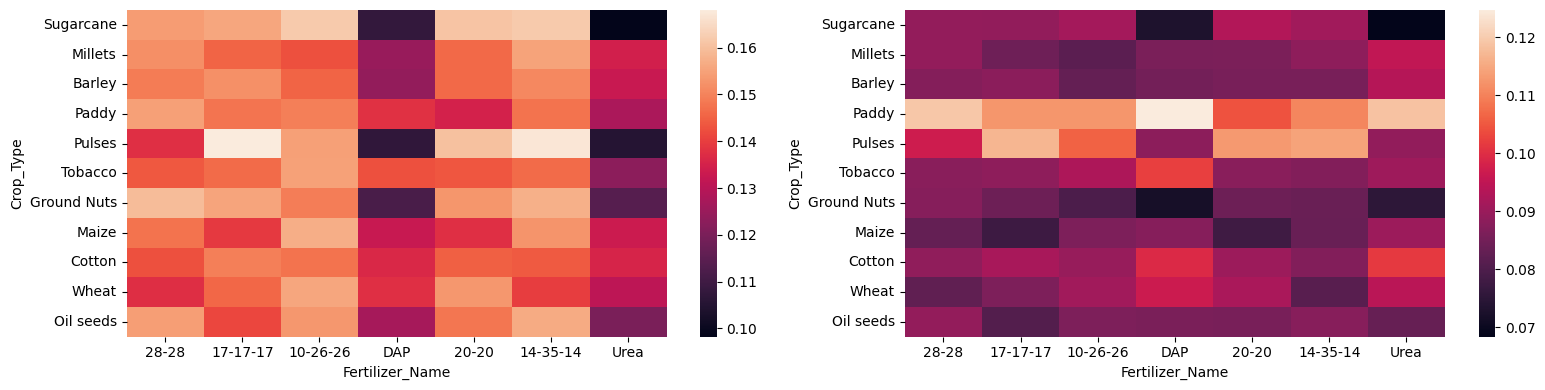

In [28]:
_, axes = plt.subplots(1, 2, figsize = (16, 4))
sns.heatmap(
    pd.crosstab(index = df_train['Crop_Type'], columns = df_train[target], normalize = 'index'), ax = axes[0]
)
sns.heatmap(
    pd.crosstab(index = df_train['Crop_Type'], columns = df_train[target], normalize = 'columns'), ax = axes[1]
)
plt.tight_layout()
plt.show()

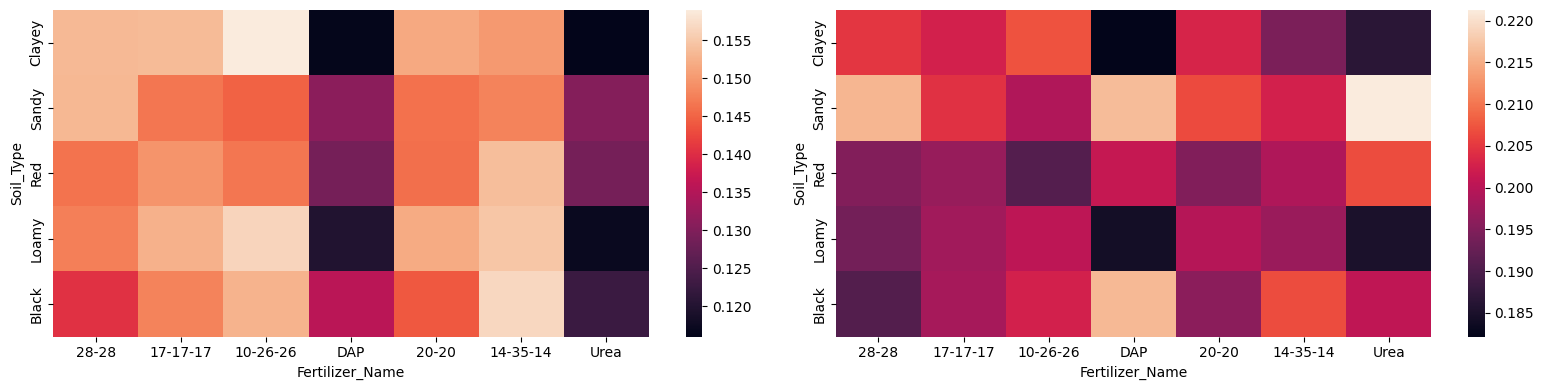

In [29]:
_, axes = plt.subplots(1, 2, figsize = (16, 4))
sns.heatmap(
    pd.crosstab(index = df_train['Soil_Type'], columns = df_train[target], normalize = 'index'), ax = axes[0]
)
sns.heatmap(
    pd.crosstab(index = df_train['Soil_Type'], columns = df_train[target], normalize = 'columns'), ax = axes[1]
)
plt.tight_layout()
plt.show()

In [30]:
s_cat_tbl = df_train.pivot_table(index = X_cat, columns = target + '_l', aggfunc = 'size', observed = True).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
s_cat_tbl.head()

Fertilizer_Name_l           0         1         2         3         4  \
Soil_Type Crop_Type                                                     
Clayey    Sugarcane  0.157391  0.166497  0.159981  0.166026  0.156527   
          Millets    0.148728  0.154932  0.148728  0.146635  0.168192   
          Barley     0.170493  0.147130  0.151576  0.152385  0.156346   
          Paddy      0.155073  0.150517  0.156550  0.138143  0.155504   
          Pulses     0.168465  0.160216  0.188252  0.158851  0.133234   

Fertilizer_Name_l           5         6  
Soil_Type Crop_Type                      
Clayey    Sugarcane  0.101892  0.091687  
          Millets    0.102280  0.130506  
          Barley     0.100728  0.121342  
          Paddy      0.129340  0.114873  
          Pulses     0.089691  0.101290

- Crop_Type과 Soil_Type 둘의 빈도를 기반으로 target의 확률을 만들었을 때 map@3를 계산해봅니다.

In [31]:
mapk_prob(df_train[target + '_l'], s_cat_tbl.loc[df_train[X_cat].apply(tuple, axis=1)].values)

0.289652

## Moisture

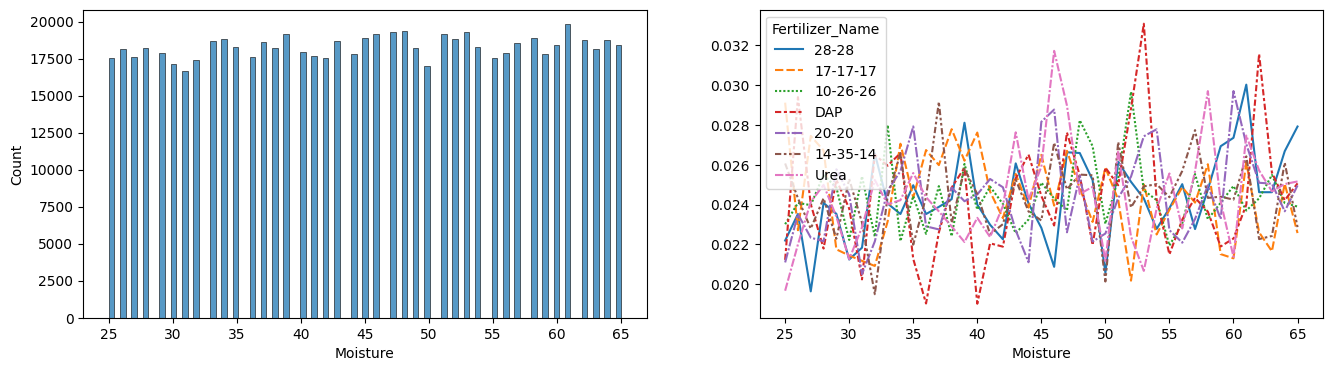

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))
sns.histplot(df_train, x = 'Moisture', ax = axes[0])
df_train.pivot_table(index = 'Moisture', columns = target, aggfunc = 'size', observed = True).pipe(
    lambda x: sns.lineplot(x.divide(x.sum(), axis = 1), ax = axes[1])
)
plt.show()

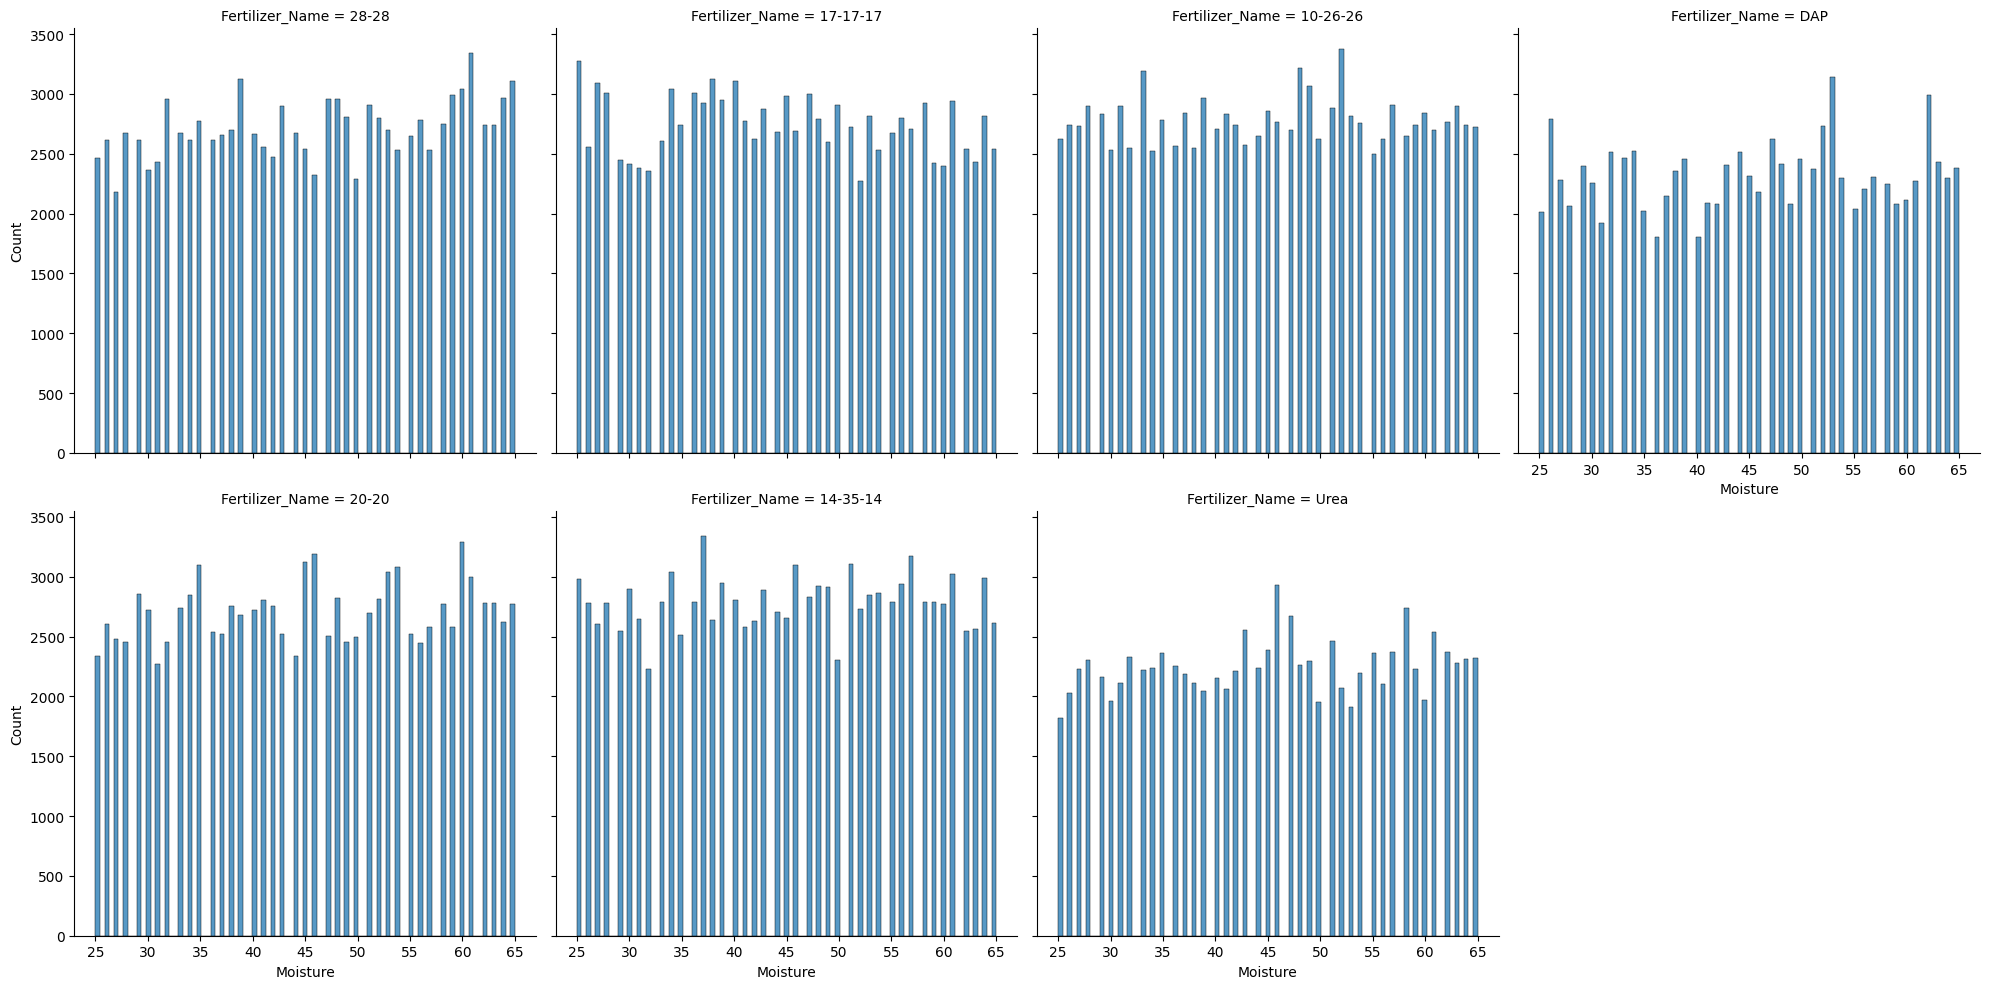

In [33]:
sns.displot(df_train, x = 'Moisture', col = target, col_wrap = 4)
plt.show()

## Potassium

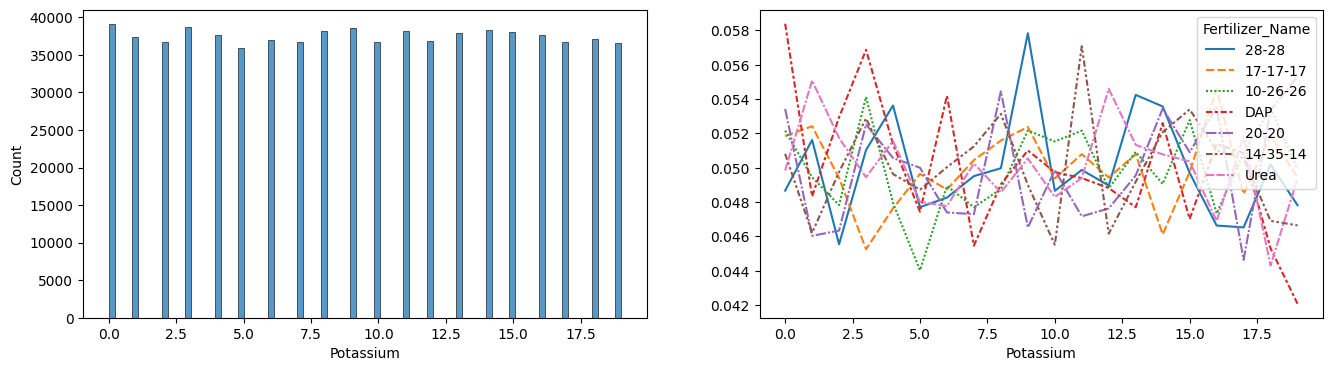

In [34]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))
sns.histplot(df_train, x = 'Potassium', ax = axes[0])
df_train.pivot_table(index = 'Potassium', columns = target, aggfunc = 'size', observed = True).pipe(
    lambda x: sns.lineplot(x.divide(x.sum(), axis = 1), ax = axes[1])
)
plt.show()

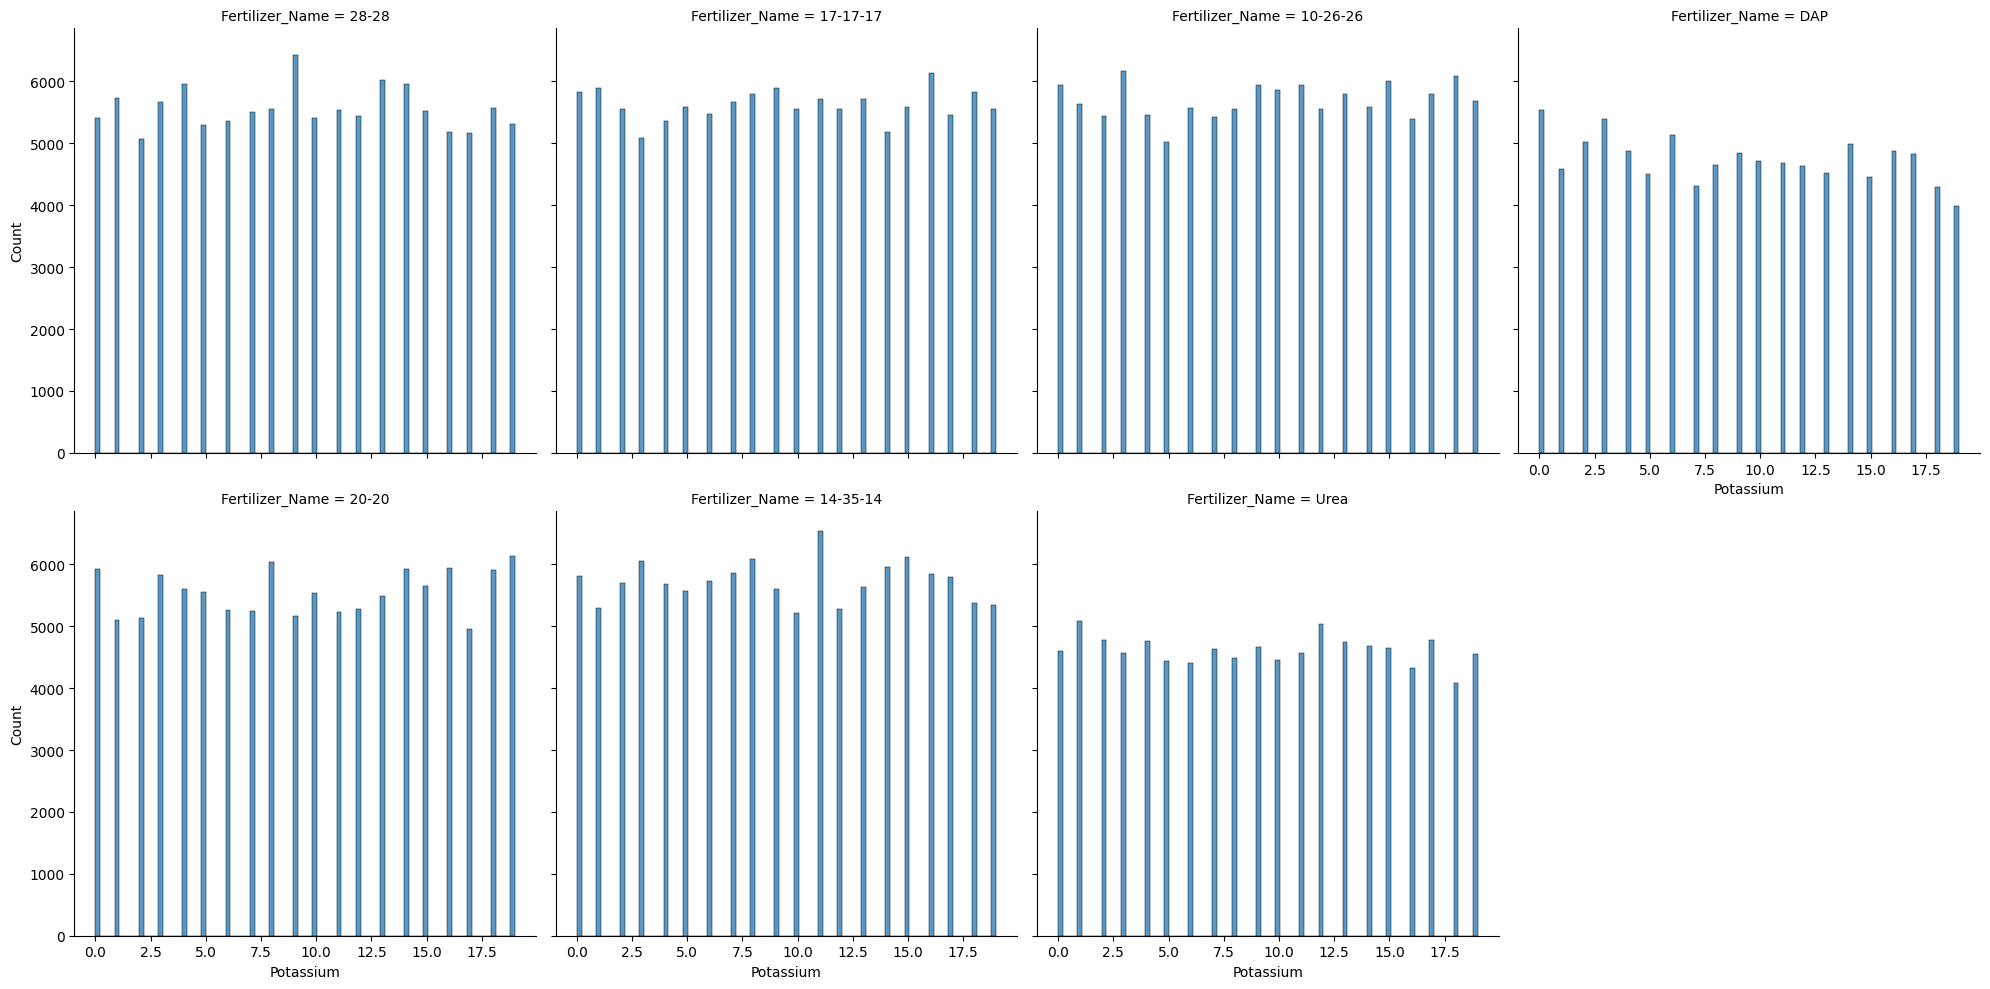

In [35]:
sns.displot(df_train, x = 'Potassium', col = target, col_wrap = 4)
plt.show()

- 시각화를 통해서 target과의 관계를 파악하는 것은 쉽지 않아 보입니다.

- 상관도 분석을 활용해서 파악합니다.

## Soil_Type과 Crop_Type별 Target과 수치형 변수와의 관계

In [36]:
df_f_pvalue = df_train.groupby(X_cat, observed = True)[X_num + [target]].apply(
    lambda x: x[X_num].apply(
        lambda y: f_oneway(*y.rename('v').astype('float').to_frame().groupby(x[target], observed = True)['v'].agg(list)).pvalue
    )
)
df_f_pvalue

Temparature  Humidity      Moisture      Nitrogen  \
Soil_Type Crop_Type                                                        
Clayey    Sugarcane       0.504643  0.003135  7.879403e-03  2.014720e-03   
          Millets         0.439889  0.813213  5.344257e-05  7.732047e-03   
          Barley          0.559525  0.049044  3.631476e-01  1.322406e-01   
          Paddy           0.000254  0.010224  2.059625e-04  1.903075e-02   
          Pulses          0.220688  0.014498  2.753886e-09  1.604249e-02   
          Tobacco         0.040744  0.131338  5.079292e-02  4.557547e-04   
          Ground Nuts     0.011514  0.000074  2.338390e-01  4.176331e-05   
          Maize           0.567423  0.343462  1.610796e-03  1.673956e-01   
          Cotton          0.015047  0.009650  4.011598e-03  2.381906e-01   
          Wheat           0.411521  0.018235  4.335683e-01  3.856352e-04   
          Oil seeds       0.304595  0.003931  1.445543e-01  8.809524e-04   
Sandy     Sugarcane       0.088591  0.001179  5.645908e-04  6.210950e-02   
          Millets         0.100240  0.420426  1.545950e-02  2.714017e-03   
          Barley          0.081484  0.140512  1.197131e-01  2.525281e-03   
          Paddy           0.181804  0.486004  1.582205e-05  1.451069e-05   
          Pulses          0.553402  0.016897  2.761194e-07  9.351894e-03   
          Tobacco         0.005023  0.001780  1.782045e-04  4.141530e-02   
          Ground Nuts     0.073099  0.010913  2.393007e-01  2.376619e-02   
          Maize           0.580923  0.003509  2.368342e-04  3.634058e-01   
          Cotton          0.293034  0.001503  4.583505e-01  7.845700e-07   
          Wheat           0.102965  0.005057  6.205261e-01  2.662098e-01   
          Oil seeds       0.295654  0.000798  4.905547e-02  5.886398e-02   
Red       Sugarcane       0.086204  0.961059  9.305684e-05  3.033517e-01   
          Millets         0.089317  0.009713  1.502684e-05  5.436612e-05   
          Barley          0.395965  0.046106  2.132113e-03  8.465870e-02   
          Paddy           0.005372  0.039877  1.617867e-05  4.395615e-03   
          Pulses          0.297480  0.326309  2.335405e-03  5.085303e-03   
          Tobacco         0.295012  0.177811  1.000243e-03  1.095426e-02   
          Ground Nuts     0.146303  0.488822  3.092477e-03  1.436552e-02   
          Maize           0.834410  0.104926  4.665945e-03  1.923186e-02   
          Cotton          0.000264  0.432964  5.204953e-03  7.197837e-01   
          Wheat           0.296879  0.429421  4.996560e-01  7.176598e-01   
          Oil seeds       0.000001  0.002990  3.339915e-01  9.432553e-03   
Loamy     Sugarcane       0.005845  0.924670  5.951198e-03  6.460726e-02   
          Millets         0.501931  0.010040  9.158775e-02  3.413619e-04   
          Barley          0.711429  0.033559  1.577698e-01  7.691121e-02   
          Paddy           0.230541  0.131267  2.322094e-04  5.567825e-02   
          Pulses          0.523656  0.001332  4.130673e-03  1.008852e-01   
          Tobacco         0.156546  0.000137  1.804239e-01  6.054544e-02   
          Ground Nuts     0.014926  0.890346  2.244757e-03  1.976295e-02   
          Maize           0.752011  0.264937  2.918824e-02  1.771809e-01   
          Cotton          0.000025  0.505700  1.201989e-04  2.526974e-01   
          Wheat           0.632497  0.224072  1.492390e-01  1.309547e-01   
          Oil seeds       0.381733  0.082814  8.522217e-01  4.373106e-03   
Black     Sugarcane       0.011564  0.000835  1.391119e-01  2.791032e-01   
          Millets         0.184535  0.027125  6.553941e-02  5.394484e-03   
          Barley          0.335193  0.008549  2.258982e-03  9.606861e-02   
          Paddy           0.064699  0.791722  2.500267e-04  1.695401e-01   
          Pulses          0.078025  0.000015  1.195359e-02  4.440915e-02   
          Tobacco         0.005354  0.069374  4.762402e-02  1.684974e-03   
          Ground Nuts     0.524908  0.017893  2.416046e-04  2.892526e-0

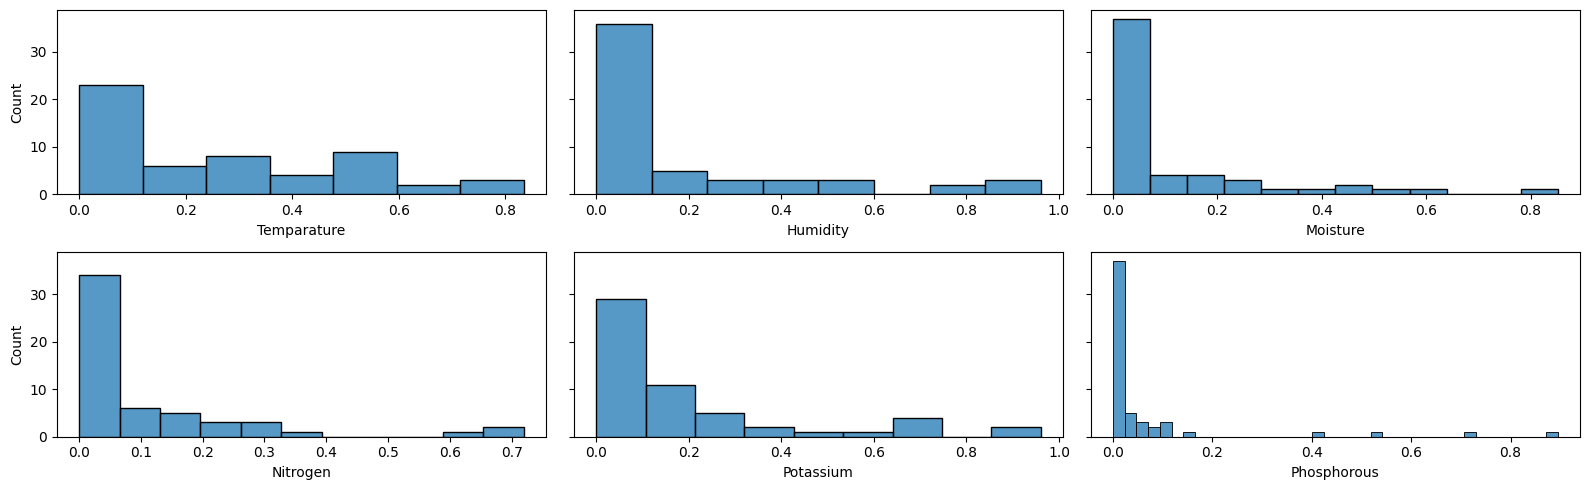

In [37]:
fig, axes = plt.subplots(2, 3, figsize = (16, 5), sharey = True)
for i, ax in zip(X_num, axes.flatten()):
    sns.histplot(df_f_pvalue, x = i, ax = ax)
plt.tight_layout()
plt.show()

- Soil_Type과 Crop_Type 별로 연속형 변수가 target과의 상관도는 다르게 나타납니다. 

- Soil_Type과 Crop_type을 통제했을 때, 가장 상관도가 큰 연속형 변수는 Phosphorous 입니다.

- Soil_Type과 Crop_Type 별로 로지스틱 회귀모델을 만들어 성능을 측정해봅니다.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

s_lr = df_train.groupby(X_cat, observed = True)[X_num + [target + '_l']].apply(
    lambda x: make_pipeline(StandardScaler(), LogisticRegression()).fit(x[X_num], x[target +'_l'])
)

In [39]:
df_prd = df_train.groupby(X_cat, observed = True, group_keys = False)[X_num].apply(
    lambda x: pd.DataFrame(s_lr.loc[x.name].predict_proba(x), index = x.index)
)

In [40]:
mapk_prob(df_train[target + '_l'], df_prd)

0.29992844444444444

# Build ML rountine

In [21]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import sgml
import pandas as pd
import numpy as np
import sgnn

ss = StratifiedShuffleSplit(1, random_state = 123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction, stratify = x[target + '_l'])

def train_data_proc(x, org = None):
    if org is not None:
        return pd.concat([x, org], axis = 0)
    else:
        return x

config = {
    'predict_func': lambda m, df, X: pd.DataFrame(m.predict_proba(df[X]), index = df.index),
    'score_func': lambda df, prds: mapk_prob(df[target + '_l'], prds),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'train_data_proc': train_data_proc,
    'y': target + '_l',
}

xgb_adapter = sgml.XGBAdapter(xgb.XGBClassifier, progress = 50)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMClassifier, progress = 50)
cb_adapter = sgml.CBAdapter(cb.CatBoostClassifier, progress = 50)
nn_adapter = sgnn.NNAdapter(sgnn.NNClassifier, progress = 100)
lr_adapter = sgml.SklearnAdapter(LogisticRegression)

In [42]:
result = sgml.cv(
    df_train, ss,
    {'model_params': {'n_estimators': 300}, 'X_num': X_num, 'X_cat': X_cat}, 
    config, cb_adapter, result_proc = [sgml.cb_interaction_importance, sgml.cb_learning_result]
)

In [43]:
result['valid_scores'], result['train_scores']

([0.32209777777777776], [0.3544659259259259])

In [44]:
result['model_result'][0].iloc[:20]

,Var1,Var2,Importance
0,cat__Soil_Type,cat__Crop_Type,12.655478
1,cat__Crop_Type,pt__Phosphorous,5.484331
2,cat__Crop_Type,pt__Moisture,4.652307
3,pt__Nitrogen,pt__Phosphorous,3.839844
4,cat__Crop_Type,pt__Humidity,3.783995
5,pt__Moisture,pt__Phosphorous,3.546115
6,cat__Crop_Type,pt__Temparature,3.418744
7,cat__Crop_Type,pt__Nitrogen,3.286372
8,pt__Moisture,pt__Nitrogen,3.243895
9,cat__Soil_Type,pt__Phosphorous,3.241841


In [22]:
result = sgml.cv(
    df_train, ss,
    {'model_params': {'n_estimators': 300}, 'X_num': X_num, 'X_cat': X_cat, 'validation_fraction': 'oof'}, 
    config, cb_adapter, result_proc = [sgml.cb_interaction_importance, sgml.cb_learning_result]
)

- Soil_Type과 Crop_Type에 상호작용이 강합니다.

In [24]:
result['model_result'][1]['feature_importance']

cat__Soil_Type      7.178106
pt__Temparature     8.054246
pt__Humidity        9.272791
pt__Potassium      11.725581
pt__Nitrogen       14.801350
pt__Moisture       15.048894
cat__Crop_Type     16.542051
pt__Phosphorous    17.376980
dtype: float64

In [46]:
result = sgml.cv(
    df_train, ss,
    {'model_params': {'n_estimators': 300}, 'X_num': X_num, 'X_cat': X_cat}, 
    config, lgb_adapter
)

In [23]:
result['valid_scores'], result['train_scores']

([0.32128666666666666], [0.34590666666666653])

In [48]:
result['model_result'][0]['feature_importance']

cat__Soil_Type      3514
pt__Temparature     5985
pt__Humidity        7463
pt__Potassium       7725
cat__Crop_Type      8636
pt__Moisture        9496
pt__Nitrogen        9706
pt__Phosphorous    10475
dtype: int32

In [49]:
result = sgml.cv(
    df_train, ss,
    {'model_params': {'n_estimators': 300, 'enable_categorical': True}, 'X_num': X_num, 'X_cat': X_cat}, 
    config, xgb_adapter
)

In [50]:
result['valid_scores'], result['train_scores']

([0.34198888888888884], [0.4675259259259259])

In [51]:
result['model_result'][0]['feature_importance']

pt__Humidity       0.111792
pt__Temparature    0.114155
pt__Potassium      0.118611
pt__Nitrogen       0.120458
pt__Moisture       0.122064
pt__Phosphorous    0.123503
cat__Soil_Type     0.132661
cat__Crop_Type     0.156756
dtype: float32

In [19]:
result = sgml.cv(
    df_train, ss,
    {
        'model_params': {'n_estimators': 300, 'enable_categorical': True}, 'X_num': X_num, 'X_cat': X_cat, 
        'train_data_proc_param': {'org': df_org}
    }, config, xgb_adapter
)

In [20]:
result['valid_scores'], result['train_scores']

([0.34901333333333334], [0.46217376344086025])

In [52]:
import tensorflow as tf
from functools import partial
def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size

def scheduler(epoch, lr, decay_epoch = 10, total_epoch = 30):
    if epoch < decay_epoch:
        return lr
    else:
        return lr * np.cos((epoch -  decay_epoch - 1) / (total_epoch - decay_epoch) * np.pi)
    
X_nn_emb = [
    ('Soil_Type', 4), ('Crop_Type', 4)
]
X_nn_cat = [i for i, _ in X_nn_emb]

nn_params = {
    'embedding':[(1, c, es, 0, 0) for _, c, es in [nn_cat_param(df_train, v, n) for v, n in X_nn_emb]], 
    'config':  [
        {'unit': 64, 'activation': 'swish', 'batch_norm': False},
        {'unit': 128, 'activation': 'swish', 'batch_norm': False},
        {'unit': 128, 'activation': 'swish', 'batch_norm': False},
        {'unit': 64, 'activation': 'swish', 'batch_norm': False},
    ]
}

hparams = {
    'model_params': {
        'model_params': nn_params,
        'epochs': 50,
        'optimizer': ('Adam', {'learning_rate': 0.001}),
        'batch_size': 512, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': {'schedule': partial(scheduler, total_epoch = 50)},
    }, 
    'X_cat': X_nn_cat, 
    'X_std': X_num,
    'validation_fraction': 0.0,
    'metrics': tf.keras.metrics.CategoricalCrossentropy()
}
result = sgml.cv(df_train, ss, hparams, config, nn_adapter)

In [53]:
result['valid_scores'], result['train_scores']

([0.2913911111111111], [0.3250140740740741])

In [54]:
result = sgml.cv(df_train, ss, {'X_std': X_num, 'X_ohe': X_cat, 'ohe': {'drop': 'first'}}, config, lr_adapter)